In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/EURON/Week 12')

In [4]:
country_data = pd.read_csv('Country-data.csv')
country_data.head(3)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460


In [5]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


# Define Clustering Target

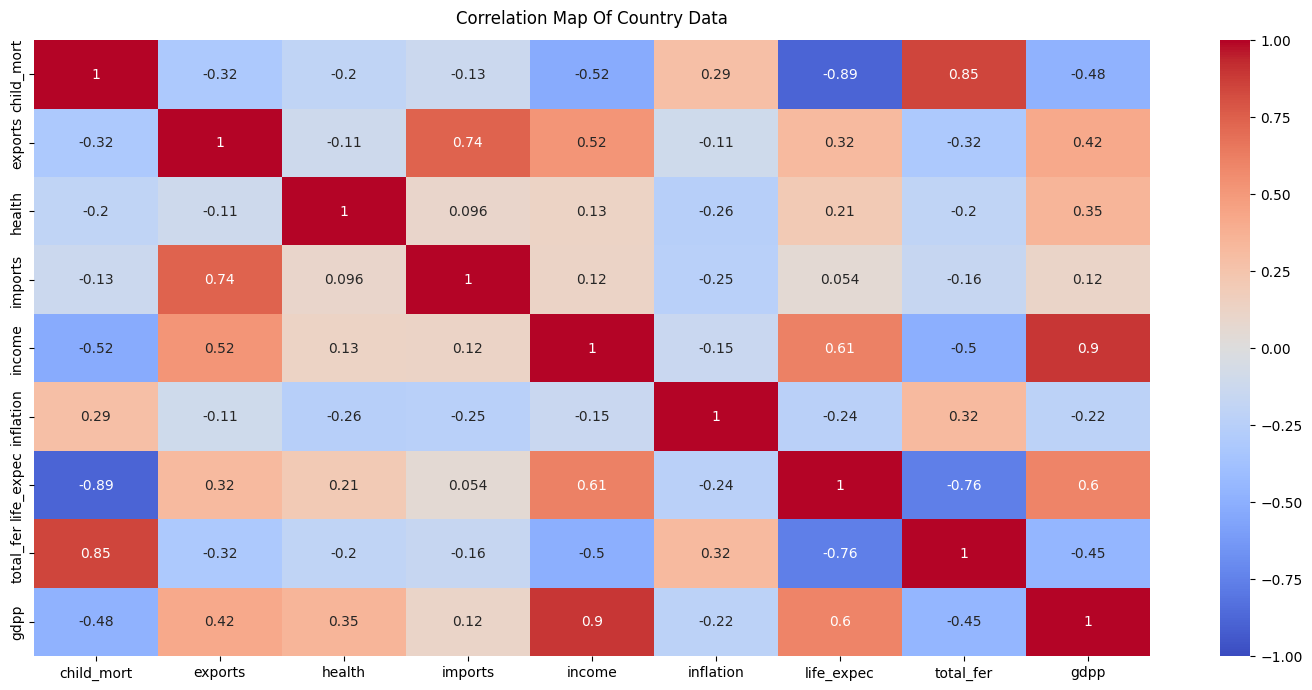

In [6]:
plt.figure(figsize=(18, 8))
sns.heatmap(country_data.corr(), vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')
plt.title('Correlation Map Of Country Data', fontdict={'fontsize':12}, pad=12);

From this heatmap, I can define the top 3 highest positive correlation score:
* ***gdpp*** and income with 0.9
* total_fer and ***child_mort*** with 0.85
* ***imports*** and exports with 0.74

I pick one of each correlation pair to see how the cluster will be made from those data. So the next step, I show you clustering between GDPP VS Child Mortality and GDPP VS Imports. Will it represent a good clustering model?

In [7]:
count_data = country_data[['child_mort', 'imports', 'gdpp']]

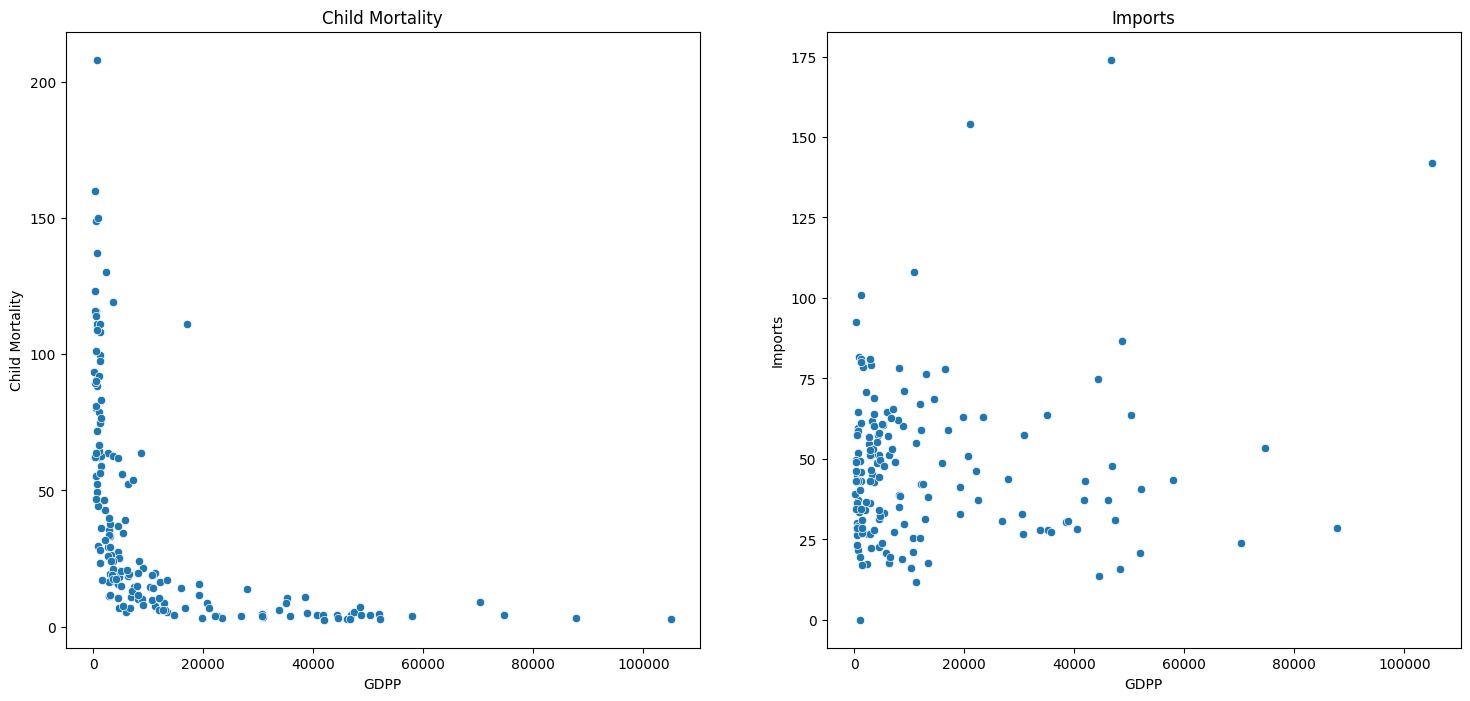

In [8]:
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'gdpp', y = 'child_mort', data = count_data)
plt.title('Child Mortality')
plt.xlabel('GDPP')
plt.ylabel('Child Mortality')
plt.subplot(1, 2, 2)
sns.scatterplot(x = 'gdpp', y = 'imports', data = count_data)
plt.title('Imports')
plt.xlabel('GDPP')
plt.ylabel('Imports')
plt.show()

Let's determine optimal number of cluster using 2 methods:
* KMeans Clustering
* DBSCAN

# KMeans Clustering

### Elbow Method

In [9]:
number_of_cluster = range(1,11)
clusterings = [KMeans(n_clusters = k).fit(count_data) for k in number_of_cluster]
centroids = [k.cluster_centers_ for k in clusterings]

D_k = [cdist(count_data, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D, axis = 1) for D in D_k]
dist = [np.min(D, axis = 1) for D in D_k]
avg_withinSS = [sum(d)/count_data.shape[0] for d in dist]

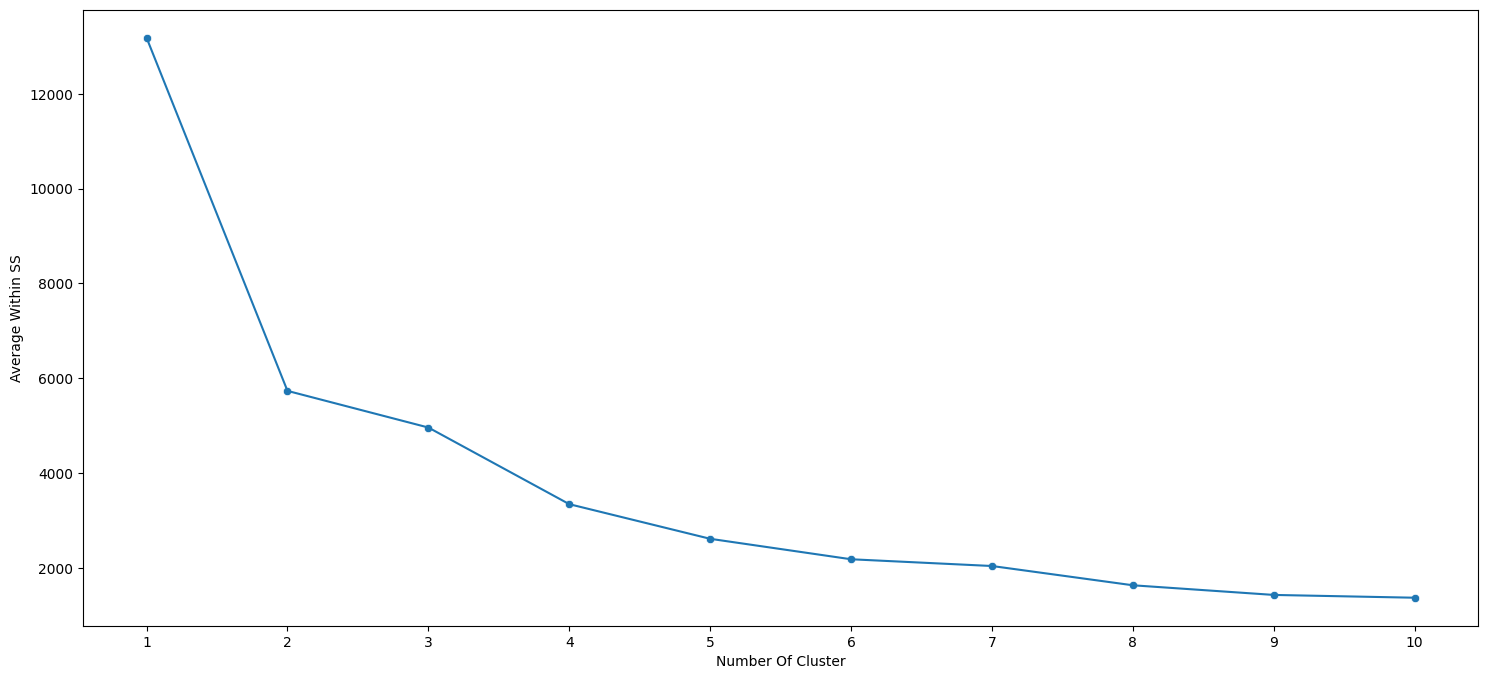

In [12]:
plt.figure(figsize=(18,8))
sns.lineplot(x=number_of_cluster, y=avg_withinSS)
sns.scatterplot(x=number_of_cluster, y=avg_withinSS)
plt.xticks(number_of_cluster)
plt.xlabel('Number Of Cluster')
plt.ylabel('Average Within SS')
plt.show()

The best n_clusters is 2 based on elbow method.

In [13]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(count_data)
country_clust = count_data.copy()
country_clust['clustkmeans'] = kmeans.labels_

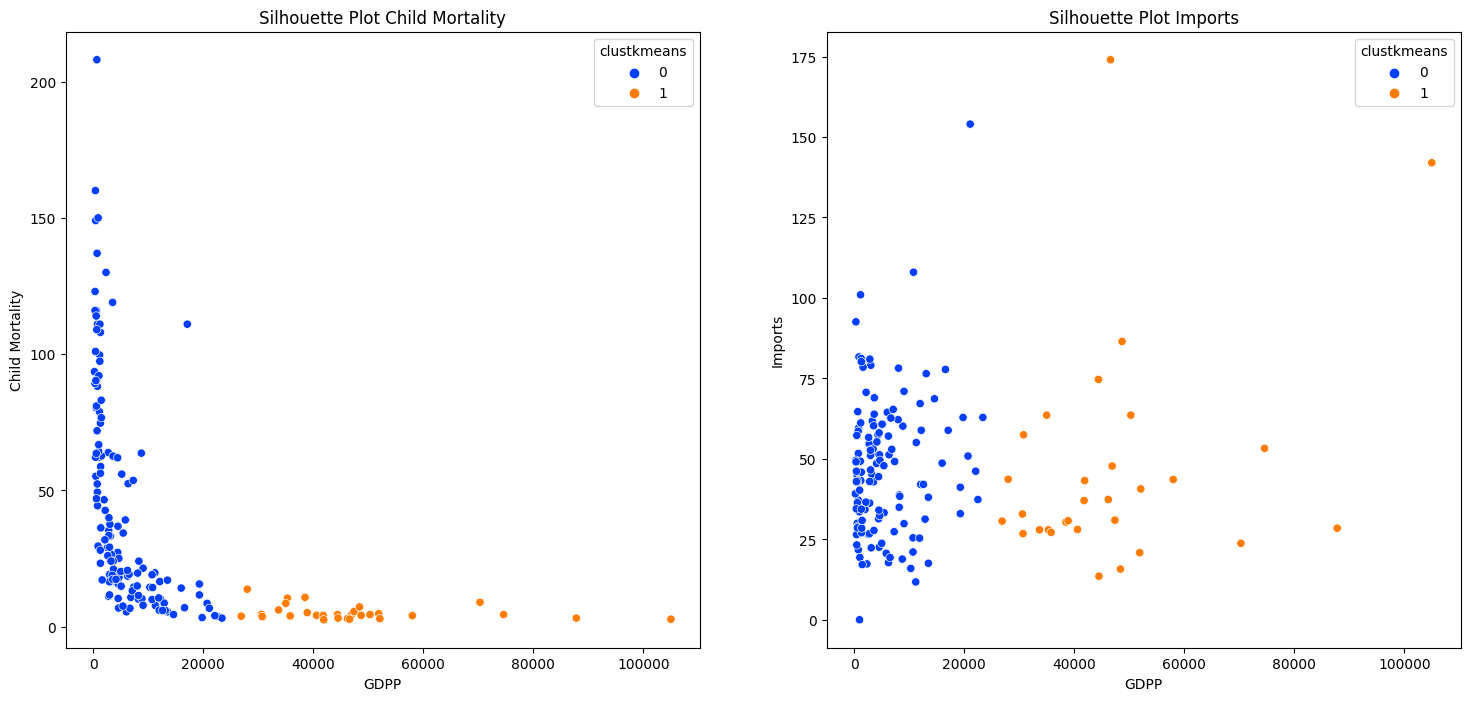

In [14]:
plt.figure(figsize = (18,8))
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'gdpp', y = 'child_mort', data = country_clust, hue = 'clustkmeans', palette = 'bright')
plt.title('Silhouette Plot Child Mortality')
plt.xlabel('GDPP')
plt.ylabel('Child Mortality')
plt.subplot(1, 2, 2)
sns.scatterplot(x = 'gdpp', y = 'imports', data = country_clust, hue = 'clustkmeans', palette = 'bright')
plt.title('Silhouette Plot Imports')
plt.xlabel('GDPP')
plt.ylabel('Imports')
plt.show()

In [15]:
cluster_name = ['Cluster 0', 'Cluster 1']
color = ['Blue', 'Orange']
mortality = ['Low GDPP VS Low to Medium Child Mortality', 'Medium GDPP VS Low Child Mortality']
imports = ['Low GDPP VS Medium Imports', 'Medium GDPP VS Medium Imports']
best_summary = pd.DataFrame({'Color': color, 'Name': cluster_name,
                        'Child Mortality': mortality, 'Imports': imports})
best_summary

,Color,Name,Child Mortality,Imports
0,Blue,Cluster 0,Low GDPP VS Low to Medium Child Mortality,Low GDPP VS Medium Imports
1,Orange,Cluster 1,Medium GDPP VS Low Child Mortality,Medium GDPP VS Medium Imports


From these plots, I can easily define that there are only 2 clusters but I can spot a few outliers or noise. On DBSCAN, I hope it can determine if there are any outliers or noise, so I can have a better clustering model.

# DBSCAN

*Optimizing Minimum Sample And Epsilon*

In [16]:
scaler = StandardScaler()
country_clust_scaled = scaler.fit_transform(country_clust)

for eps in [i/10 for i in range(2,5)]:
    for min_samples in range (7,9):
        print(f'\neps {eps}')
        print(f'\min samples {min_samples}')

        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        labels = dbscan.fit_predict(country_clust_scaled)
        score = silhouette_score(country_clust_scaled, labels)

        print(f'clusters present: {np.unique(labels)}')
        print(f'clusters sizes: {np.bincount(labels + 1)}')
        print(f'Silhouette Score: {score}')


eps 0.2
\min samples 7
clusters present: [-1  0]
clusters sizes: [156  11]
Silhouette Score: -0.2393615335452477

eps 0.2
\min samples 8
clusters present: [-1  0]
clusters sizes: [156  11]
Silhouette Score: -0.2393615335452477

eps 0.3
\min samples 7
clusters present: [-1  0  1  2]
clusters sizes: [119  30  11   7]
Silhouette Score: -0.1695682589970686

eps 0.3
\min samples 8
clusters present: [-1  0  1]
clusters sizes: [130  29   8]
Silhouette Score: -0.15138644771886964

eps 0.4
\min samples 7
clusters present: [-1  0  1]
clusters sizes: [ 53 101  13]
Silhouette Score: 0.2581064152198133

eps 0.4
\min samples 8
clusters present: [-1  0  1  2]
clusters sizes: [70 78 11  8]
Silhouette Score: 0.11859148004718649


The best hyperparam are eps: 0.4 and min samples: 7, because it has the highest silhouette score, but samples is inlcuded with noise.

In [17]:
dbscan = DBSCAN(eps = 0.4, min_samples = 7)
labels = dbscan.fit_predict(country_clust_scaled)
country_clust['clustdbscan'] = labels

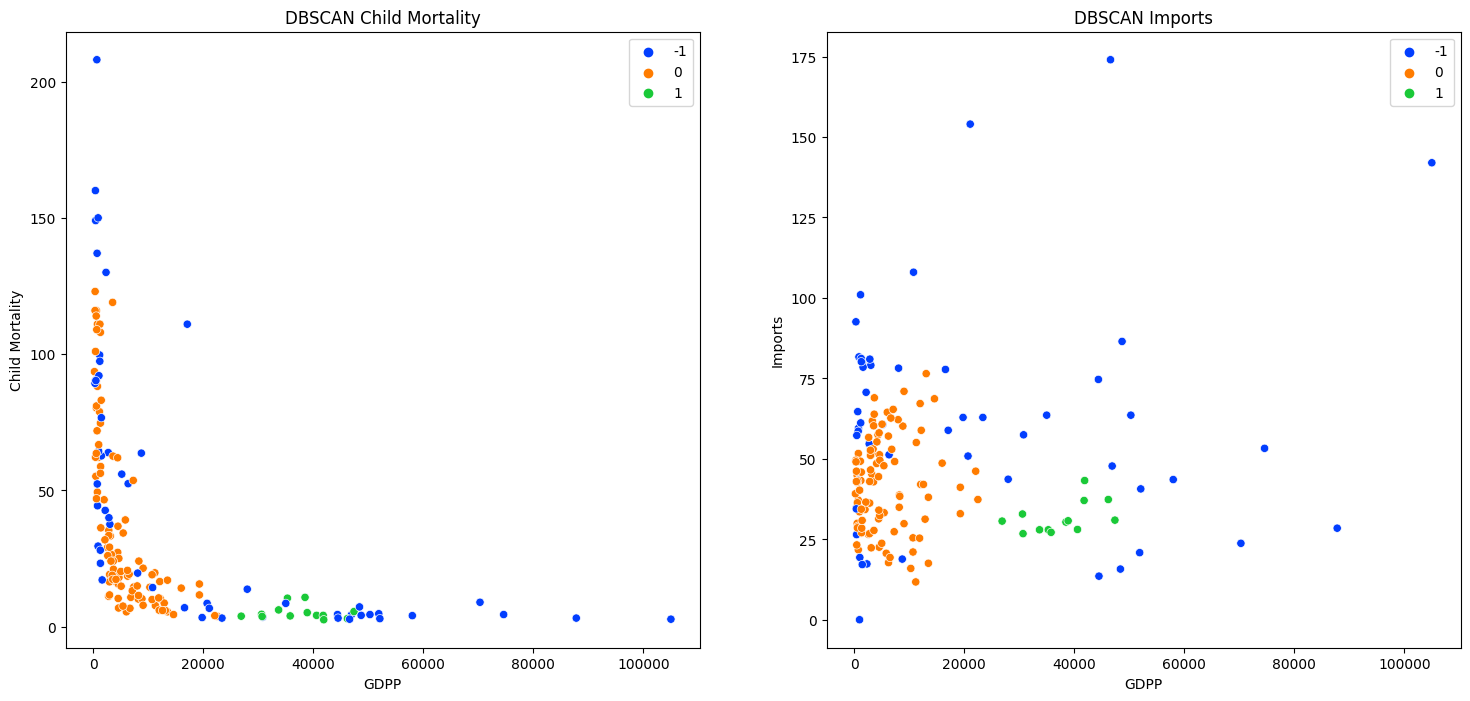

In [18]:
plt.figure(figsize = (18,8))
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'gdpp', y = 'child_mort', data = country_clust, hue = 'clustdbscan', palette = 'bright')
plt.legend(loc = 1)
plt.title('DBSCAN Child Mortality')
plt.xlabel('GDPP')
plt.ylabel('Child Mortality')
plt.subplot(1, 2, 2)
sns.scatterplot(x = 'gdpp', y = 'imports', data = country_clust, hue = 'clustdbscan', palette = 'bright')
plt.legend(loc = 1)
plt.title('DBSCAN Imports')
plt.xlabel('GDPP')
plt.ylabel('Imports')
plt.show()

In [19]:
cluster_name = ['Cluster -1', 'Cluster 0', 'Cluster 1']
color = ['Blue', 'Orange', 'Green']
mortality = ['Noise', 'Low GDPP VS Low to Medium Imports', 'Medium GDPP VS Low Imports']
imports = ['Noise', 'Low GDPP VS Medium Imports', 'Medium GDPP VS Medium Imports']
dbscan_summary = pd.DataFrame({'Color': color, 'Name': cluster_name,
                        'Child Mortality': mortality, 'Imports': imports})
dbscan_summary

,Color,Name,Child Mortality,Imports
0,Blue,Cluster -1,Noise,Noise
1,Orange,Cluster 0,Low GDPP VS Low to Medium Imports,Low GDPP VS Medium Imports
2,Green,Cluster 1,Medium GDPP VS Low Imports,Medium GDPP VS Medium Imports


Surprisingly, there is a lot of noise more than I think. With DBSCAN, I can see the accurate model.